# 第6章 向量化

本章主要介绍PyTorch中的向量化思想。其中6.1节和6.2节介绍向量化的基本概念和常用的广播法则；6.3节介绍PyTorch中的高级索引，这也是向量化思想的重点，通过高级索引操作可以简化向量的计算。

## 6.1 向量化简介

向量化计算是一种特殊的并行计算方式，指对不同的数据执行同样的一个或一批指令，或者把指令应用到一个数组或向量上，从而将多次for循环操作变成一次计算。一般来说，程序在同一时间内只执行一个操作，而并行计算可以在同一时间内执行多个操作。向量化计算的关键是分析张量的形状，一旦确定了张量形状，如何操作就呼之欲出了。

同时，向量化操作可以极大地提高科学运算的效率。Python本身是一门高级语言，使用简便，但其中存在着许多低效的操作，例如for循环等。因此，在科学计算程序中应当极力避免使用Python原生的for循环，而尽量使用向量化的数值运算，下面举例说明：


In [ ]:
import torch as t
def for_loop_add(x, y):
    result = []
    for i, j in zip(x, y):
        result.append(i + j)
    return t.tensor(result)

In [ ]:
x = t.zeros(100)
y = t.ones(100)
%timeit -n 100 for_loop_add(x, y)
%timeit -n 100 (x + y)

从上面的例子中可以看出，for循环和向量化计算之间有着数百倍的速度差距，因此在实际使用中读者应该尽量调用内建函数（buildin-function）。内建函数底层由C/C++实现，在实现中均体现了向量化计算的思想，并通过底层优化实现了高效计算。在日常编程中读者最好养成向量化的编程习惯，避免对较大的Tensor进行逐元素的遍历操作，从而提高程序的运行效率。

## 6.2 广播法则

广播法则（broadcast）是科学计算中经常使用的一个技巧，它在快速执行向量化计算的同时不会占用额外的内存/显存。PyTorch和NumPy中的广播法则定义如下。

（1）所有输入数组都与维度（n_dim）最大的数组看齐，维度不足的部分在前面加1补齐。比如，两个数组形状分别为(3,4)和(2,3,1)，前一个会自动将形状补齐为(1,3,4)。

（2）两个数组要么在某一个维度的尺寸一致，要么其中一个数组在该维度的尺寸为1，否则不能计算。比如，形状为(1,3,4)和(2,3,1)的两个数组可以计算，而形状为(1,3,4)和(2,3,2)的两个数组不能计算。

（3）如果输入数组某个维度的尺寸为1，那么计算时该数组会沿此维度复制扩充成目标的形状。比如，形状为(1,3,4)和(2,3,1)的两个数组会复制扩充成(2,3,4)。

虽然PyTorch已经支持了自动广播法则，但是笔者还是建议初学者通过以下两种方式的组合，手动实现广播法则，这样更加直观，也更不容易出错。

- `unsqueeze`、`view`或者`tensor[None]`：为数组的某一维度补1，实现法则（1）。
- `expand(*new_size)`或者`expand_as(tensor_b)`：重复数组，实现法则（3）。因为`expand`操作不会复制数组，所以不会占用额外的空间。

注意：虽然`repeat`可以实现与`expand`类似的功能，但是`expand`是在已经存在的Tensor上创建一个新的视图（view），而`repeat`会将相同数据复制多份，因而占用额外的内存空间。

In [4]:
# 比较expand和repeat的内存占用情况
a = t.arange(3).view(1, 3)
print("原始储存占用：" + str(a.storage().size()))
# expand不额外占用内存，只返回一个新的视图
b = a.expand(3, 3)
print("expand储存占用：" + str(b.storage().size()))
# repeat复制了原始张量
c = a.repeat(3, 3)
print("repeat储存占用：" + str(c.storage().size()))

原始储存占用：3
expand储存占用：3
repeat储存占用：27


In [5]:
a = t.ones(3, 2)
b = t.zeros(2, 3, 1)

# 自动广播法则
# 第一步：a是2维的，b是3维的，所以先在较小维度的a前面补1个维度，
#       即：a.unsqueeze(0)，a的形状变成(1，3，2)，b的形状是(2，3，1),
# 第二步：a和b在第一维和第三维形状不一样，其中一个为1，
#       即：可以利用广播法则扩展，两个形状都变成了(2，3，2)
(a + b).shape

torch.Size([2, 3, 2])

In [6]:
# 手动广播法则，下面两行操作是等效的
# a.view(1, 3, 2).expand(2, 3, 2)+b.expand(2, 3, 2)
a[None].expand(2, 3, 2) + b.expand(2, 3, 2)

tensor([[[1., 1.],
         [1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.],
         [1., 1.]]])

## 6.3 索引操作

索引（indexing）是高维数组中的常用操作，形如`tensor[indices]`，根据`indices`的不同类型，索引又可以分为Tensor基本索引（Basic Slicing and Indexing）和高级索引（Advanced Indexing）。本节将先从Tensor的底层实现开始，对比介绍基本索引和高级索引的相关用法，帮助读者建立向量化思想。


### 6.3.1 Tensor的底层实现

如果读者要充分理解PyTorch的索引操作，那么必须熟悉Tensor的底层实现。在3.1.3节中我们简要地介绍了Tensor的基本结构，这里我们深入分析一下它的底层原理。

Tensor的底层使用C/C++实现，它可以用于存储数据，还可以定义如何对数据进行操作。Tensor与Python list最大的区别是：Tensor利用一个连续的内存区域去存储数据，这些数据都未经过封装；list中的每个数据都会被封装成PyObject对象，每个对象独立分配内存并离散地存储在内存当中。

在PyTorch底层使用`Storage`类来管理Tensor的内存区域，它使用一个一维数组来存储数据。Tensor通过修改内部的size、storage_offset和stride属性让这个一维数组“看起来像一个多维数组”（获得多个Tensor的实例），实际上这些Tensor指向同一个`Storage`区域，下面举例说明：

In [9]:
a = t.arange(6).view(3, 2)

print(a)

b = a.reshape(2, 3)   # 改变形状
c = a.transpose(1, 0) # 转置
d = a[:2, 1]          # 切片

print(d)

# a，b，c，d四个实例指向同一个storage
a.storage().data_ptr() == b.storage().data_ptr() == c.storage().data_ptr() == d.storage().data_ptr()

tensor([[0, 1],
        [2, 3],
        [4, 5]])
tensor([1, 3])


True

In [8]:
# 发生改变的实际是三个内部属性：size，storage_offset和stride
print(a.size(), a.storage_offset(), a.stride())
print(b.size(), b.storage_offset(), b.stride())
print(c.size(), c.storage_offset(), c.stride())
print(d.size(), d.storage_offset(), d.stride())

torch.Size([3, 2]) 0 (2, 1)
torch.Size([2, 3]) 0 (3, 1)
torch.Size([2, 3]) 0 (1, 2)
torch.Size([2]) 1 (2,)


关于这三个属性的说明如下。

（1）size：控制Tensor每个维度上的取值范围，`reshape`操作、切片操作等都会修改Tensor实例的size属性。

（2）storage_offset：Tensor开始元素对应存储区Storage的索引，因为部分Tensor实例只使用了一部分Storage，所以该属性能控制每个实例的起始位置。

（3）stride：一个元组，stride的第k个元素表示Tensor的第k个维度中两个元素之间的内存间隔，这一概念使得Tensor的高级索引运算变得更加高效。

![图6-1  Tensor的底层结构](imgs/Tensor_basic_structure.png)

图6-1解释了一个高维Tensor是怎样从一个一维数组上存取数据的。我们可以通过storage_offset属性和stride属性，结合维度信息计算出任意位置元素在一维Storage上的索引offset，计算方法如式(6.1)所示。

$$\text{offset}=\sum_{k=0}^{N-1}\text{stride}_{k}\times \text{dim}_{k}+\text{storage_offset}\tag{6.1}$$

其中，$\text{dim}$表示所取元素的所在的维度。下面举例说明如何应用该式进行计算：

In [10]:
a = t.arange(12).view(3, 4)
a, a.size(), a.storage_offset(), a.stride()

(tensor([[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11]]),
 torch.Size([3, 4]),
 0,
 (4, 1))

如果想要获取第二行第三列的元素$a[1,2]$，那么可以通过式(6.1)得出：$\text{offset}=4\times1+1\times2+0=6$，也就是Storage中的第7个元素，这与$a[1,2]$得到的值相同。stride元组的计算极为简单，它可以视为多维数组向一维数组映射的权重，它的取值只与当前Tensor实例的size属性有关，计算方法如式(6.2)所示。

$$\text{stride}_k=\prod_{j=k+1}^{N-1} \text{DimNum}_{j}\tag{6.2}$$

其中，$\text{DimNum}_{j}=\text{self.shape}[j]$，stride元组的末尾元素默认为1。

注意：必须在`tensor.is_contiguous=True`的时候，才可以使用这个式(6.2)计算$\text{stride}$。

In [11]:
# a的size设为2×3×4×5
a = t.rand(2, 3, 4, 5)
# 可以通过式(6.2)计算得到，stride0=3×4×5=60，stride1=4×5=20，stride2=5，stride3=1
a.stride()

(60, 20, 5, 1)

总结：对Tensor的许多操作都可以通过改变Tensor的size、stride、offset等属性实现，更改这些属性前后的Tensor共享同一个存储区域，可以节省内存。


### 6.3.2 基本索引


PyTorch中Tensor的索引和NumPy数组的索引类似，通过索引操作可以定位到数据具体的位置。基本索引是将Python中的切片概念扩展到了N维的形式。通过基本索引生成的所有Tensor都是原始Tensor的视图（view），它们和原始Tensor共享Storage。基本索引有以下几种形式，它们适用于每个维度的基本切片操作。

（1）Tuple对象`Tensor[(IntA, IntB, IntC)]`或`Tensor[IntA, IntB, IntC]`：在索引中直接使用一个元组序列（tuple）对Tensor中数据的具体位置进行定位，也可以直接使用多个整数（元组序列省略括号的形式），后者是前者的语法糖。 

（2）Slicing对象`Tensor[start:stop:step]`：切片对象`start:stop:step` 代表从`start`开始，每隔`step`个元素取一个，直到`stop`。这种形式有几种特殊情况，如`start:`，`:stop`，`start:stop`，`::step`和`:`。

（3）省略号对象（`...`）：在索引中常用省略号（ellipsis）来代表一个或多个维度的切片，等效于一个或多个`:`。

（4）`None`对象：与NumPy中的`newaxis`相同，`None`在PyTorch索引中起到增加一个维度的作用。


下面举例说明这几种基本索引的使用方式。

#### Tuple对象

元组序列的操作形如`Tensor[(IntA, IntB, IntC)]`或`Tensor[IntA, IntB, IntC]`，后者是前者的语法糖。其中，IntA，IntB和IntC分别代表着三个维度的下标。如果下标的数目，少于Tensor的维度数，我们默认在后面加`:`，即用切片选择剩下的维度。`Tensor[IntA, IntB]`等价于`Tensor[IntA, IntB, :]`。


In [12]:
a = t.arange(1, 13).view(3, 4)
a

tensor([[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12]])

In [13]:
# 提取位置第二行，第三列的元素, 等价于a[(1, 2)]（保留括号的元组形式）
a[1, 2]

tensor(7)

In [16]:
# 固定第一个维度，提取第二个维度上的切片（省略第二个参数），等价于a[1,:]
a[1]
a[1,:]

tensor([5, 6, 7, 8])

注意：`a[(0, 1)]`与`a[[0, 1]]`、`a[(0, 1),]`并不等价，后面两个索引用作选取第1，2行元素，它们不属于基本索引，而属于高级索引的范畴，这部分内容将在6.3.3节中进行讲解。

#### Slicing对象

切片对象的基本语法形式为：`start:stop:step`，`start`是起始索引，`stop`是终止索引，`step`是步长（`step>0`）。从`start`开始，每隔`step`个元素取一个，直到`stop`。取值范围包括`Tensor[start]`但不包括`Tensor[stop]`。切片对象有以下几种特殊情况/变形（假设，N是当前维度的大小）。

- `start:stop`，默认step=1。
- `start:`，默认stop=N，step=1。
- `:stop`，默认start=0，step=1。
- `::step`，等价于`0:N:step`。
- `:`或`::`，全选这一维度，等价于`0:N:1`。
- `start`或`stop`为负数，等价于`N-start`或`N-stop`。
- `step`为负数，意思是反向索引，NumPy支持，但是PyTorch不支持。
- tuple索引可以看成是切片索引的特例，比如`Tensor[IntA, IntB, IntC]`，近似但不等于`Tensor[IntA:IntA+1, IntB:IntB+1, IntC:IntC+1]`。
- `...`代表一个或多个`:`，具体代表多少个`:`，取决于数组的维度。最终的索引个数和数组维度数一致。 
- 形如`Tensor[idx1, idx2]`, 如果idx的数目小于Tensor的维度（Tensor.ndim），默认在后面补多个`:`或一个`...`。这一点对基本索引和高级索引都适用。


In [17]:
a = t.arange(10)
a[1:8:2]

tensor([1, 3, 5, 7])

In [18]:
# start或stop为负数
a[-5:-1:2], a[(10-5):(10-1):2]

(tensor([5, 7]), tensor([5, 7]))

In [20]:
print(a)

#step为负数，只有numpy支持
a_numpy = a.numpy()[8:2:-3]
# PyTorch可以用t.flip函数，注意：下标需手动计算。flip函数创建新Tensor，不共享存储
a_tensor = t.flip(a[5:9:3], [0])
# 或者用t.arange, 这种方式属于高级索引
a_tensor_2 = a[t.arange(8, 2, -3)]

a_numpy, a_tensor, a_tensor_2

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


(array([8, 5]), tensor([8, 5]), tensor([8, 5]))

In [ ]:
a = t.rand(3, 224, 224)
print(a[:, 0:224:4, :].shape) # 第二个维度间隔切片
print(a[:, ::4].shape) 
# ::4 表示对第二个维度（列）进行步长为 4 的切片操作

# 默认在后面缺失的维度补`:`全选。另默认start=0，stop=224

torch.Size([3, 56, 224])
torch.Size([3, 56, 224])


In [22]:
a = t.arange(12).view(2, 3, 2)
print(a)
print(a[1:2]) # 等价于a[1:2, :, :]

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]]])
tensor([[[ 6,  7],
         [ 8,  9],
         [10, 11]]])


注意：当索引为整数`i`和切片对象`i:i+1`时，虽然它们返回的值是相同的，但是得到的索引结果维度是不同的。直接使用整数`i`作为索引会比使用切片对象`i:i+1`作索引少一个维度。如果原始Tensor的维度是1，那么使用整数作为索引后返回的是一个标量值。

In [ ]:
# 使用整数作索引
a_int = a[:, 1]   # 第0维全部取出，第1维取出第2个元素
# 使用切片对象作索引
a_slice = a[:, 1:2]
print(a_int.shape, a_slice.shape)
print(a_int)
print(a_slice)

torch.Size([2, 2]) torch.Size([2, 1, 2])
tensor([[2, 3],
        [8, 9]])
tensor([[[2, 3]],

        [[8, 9]]])


省略号`...`表示可以省略任意多个`:`表示的维度，一般情况下，一个索引中只会使用一次`...`。至于`...`到底代表了多少个`:`，取决于在它前面和后面各有多少个索引元素，最终总共索引元素的个数要等于数组的维度。 

In [26]:
# a是三维数组
print(a[1:2, ...]) # 等价于a[1:2,:,:]，补两个 :
print(a[1, ..., 0]) # 等价于a[1,:,0], 补 一个 :

tensor([[[ 6,  7],
         [ 8,  9],
         [10, 11]]])
tensor([ 6,  8, 10])


#### `None`索引

`None`索引常用于在结果Tensor上扩展一个新的维度，增加的这个维度正好是`None`索引的位置。在PyTorch的源码中，`None`索引就经常被使用。`None`索引可以直观地表示维度的扩展，在广播法则中充当1的作用。使用`None`索引，本质上与使用`unsqueeze`函数是等价的，都能起到扩展维度的作用。但是，在维度较多的情况下，或者需要对多个维度进行扩展再进行矩阵计算时，使用`None`索引会更加清晰直观。因此，笔者强烈推荐使用`None`索引进行维度的扩展，下面举例说明：

In [27]:
a = t.rand(2, 3, 4, 5)
# 在最前面加一个维度，下面两种写法等价
print(a.unsqueeze(0).shape)
print(a[None,...].shape)

torch.Size([1, 2, 3, 4, 5])
torch.Size([1, 2, 3, 4, 5])


In [28]:
# 在原有的四个维度中均插入一个维度，成为（2,1,3,1,4,1,5）
# unsqueeze方法，每成功增加一个维度，需要重新计算下一个需要增加的维度位置
b = a.unsqueeze(1).unsqueeze(3).unsqueeze(5)
b.shape

torch.Size([2, 1, 3, 1, 4, 1, 5])

In [29]:
# None索引方法，直接在需要增加的维度上填写None即可
a[:,None,:,None,:,None,:].shape

torch.Size([2, 1, 3, 1, 4, 1, 5])


下面再例举一个使用`None`索引的例子。假设Tensor $a$是一组图像的feature maps经过全连接层后的结果，维度是$\text{batch_size}\times \text{features}$，现在需要构建一个每两张图像之间的关系矩阵，读者可以思考一下如何使用`None`索引进行构建。

处理这样一个问题，最直观的想法就是进行矩阵的乘法：将n×1维的矩阵与1×n维的矩阵相乘，结果就是n×n维的矩阵。因此，将Tensor $a$的第二个维度进行扩展并转置得到$a^T$，再使用矩阵的乘法即可：

In [32]:
# 假设batch_size为16，features为256
a = t.arange(16 * 256).view(16, 256)
a1 = a.unsqueeze(1)
a_T = a1.transpose(2, 1)
a_matrix = a_T @ a1 # @表示矩阵的乘法
a_matrix.shape

torch.Size([16, 256, 256])

使用`None`索引和广播法则解决这个问题将更加地直观：

In [33]:
b = a[:,:,None] * a[:,None,:]
c = a[:,None,:] * a[:,:,None]
# 读者可以思考一下，b和c有什么区别？
b.shape, c.shape

(torch.Size([16, 256, 256]), torch.Size([16, 256, 256]))

In [34]:
assert t.equal(b, c)
assert t.equal(a_matrix, b)
# 没有触发异常，说明两种方式得到的结果是一样的

从上面的结果可以看出，$b$和$c$虽然写法不一样，但是最终结果是一样的。这是因为使用`None`索引进行维度扩展时，扩展的维度是1。当维度中有1存在时，Tensor相乘会触发广播法则，并在计算的时候自动填充，所以最终的结果是一致的。



相比于高级索引，基本索引生成的所有Tensor都是原始Tensor的视图，它们和原始Tensor共享Storage。基本索引只会改变stride、offset等属性，然后返回原始Tensor的视图，下面举例说明：

In [35]:
a = t.arange(12).view(3, 4)
b = a[1:, None] # 基本索引得到b
print(b.shape)
a.storage().data_ptr() == b.storage().data_ptr() # a和b共享Storage

torch.Size([2, 1, 4])


True

In [36]:
# 基本索引只是返回了一个新的视图，具有不一样的stride、offset等属性
print(a.storage_offset() == b.storage_offset())
print(a.stride() == b.stride())

False
False



至此，我们介绍了PyTorch中的基本索引操作，下面我们将介绍更能体现向量化思想的高级索引操作，读者需要注意区分二者之间的不同。

### 6.3.3 高级索引

与基本索引相比，高级索引的触发条件不同，返回值也有所不同。高级索引的基本要求是`Tensor[idx1, idx2, ...]`的索引元素（idx）中至少包含一个Tensor或Tuple/List。常见的高级索触发条件有以下三种。再次强调 `tensor[Int1, Int2]` 等价于 `tensor[(Int1, Int2)]`，前者是后者的语法糖。

（1）索引是Tensor。索引是一个包括整数类型或者布尔类型的Tensor。

（2）索引是List，如`Tensor[[0,1]]`。注意和`Tensor[(0,1)]` 进行区别，后者是基本索引。

（3）索引是Tuple并且里面至少包含另一个Tuple/List或者Tensor，如 `Tensor[1, [1,2,3]]`。

（4）特例：为了保持与通用用法的向后兼容，如果索引对象是任何包含切片对象、省略号对象或`None`对象的非张量序列（如List），而不是整数类型的Tensor，那么会触发基本索引，而不是高级索引。这种情况比较少见，也不建议使用。


注意：高级索引的返回值是原始Tensor的拷贝（copy）而不是视图（view），这是和基本索引最重要的不同。

In [38]:
a = t.arange(12).view(2, 2, 3)

print(a)
print(a[0,1])
a[0, 1].shape # 基本索引，等价于a[(0, 1)]

tensor([[[ 0,  1,  2],
         [ 3,  4,  5]],

        [[ 6,  7,  8],
         [ 9, 10, 11]]])
tensor([3, 4, 5])


torch.Size([3])

In [ ]:
a[[0, 1]].shape # 高级索引，索引是List

print(a[[0,1]])

tensor([[[ 0,  1,  2],
         [ 3,  4,  5]],

        [[ 6,  7,  8],
         [ 9, 10, 11]]])


In [41]:
a[t.tensor([0, 1])].shape # 高级索引，索引是Tensor

torch.Size([2, 2, 3])

In [42]:
a[([0, 1], 1)].shape # 高级索引，索引是Tuple但是包含Tuple/List/Tensor

torch.Size([2, 3])

In [43]:
a[[0, None]].shape # 特殊情况，None触发基本索引，等价于a[0, None]

torch.Size([1, 2, 3])

#### Integer Array Indexing


这里我们主要介绍高级索引的第一种情况，也就是索引是一个整数数组（Integer Array Indexing），上面给的例子是这一小节的特例。

整数数组索引可以根据$N$维索引选取数组中的任意项。一般情况下，整数数组索引需要提前确定输入输出Tensor的形状，这是因为所有的整数索引都有一个相对固定的模式：$\text{tensor}[\text{index}_1, \text{index}_2, ..., \text{index}_N]$。

其中，$N$的大小必须小于等于这个Tensor的维度（`Tensor.ndim`）。如果经过索引操作后得到的Tensor形状是$M_1 \times M_2 \times ... \times M_K$，那么这个Tensor的所有索引$\text{index}_1 ... \text{index}_N$的形状都必须是$M_1 \times M_2 \times ... \times M_K$，同时输出的第$[m_1,m_2,...,m_K]$个元素是$\text{tensor}[\text{index}_1[m_1,m_2,...,m_K], \text{index}_2[m_1,m_2,...,m_K], ..., \text{index}_N[m_1,m_2,...,m_K]]$。

为了便于了解，我们可以先假设$\text{index}_i$都是一维的数组，并且他们的形状都一样，从而输出的形状也和$\text{index}_i$一样。

In [44]:
a = t.arange(12).view(3, 4)
a

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])

In [45]:
# 构造相同形状的索引，行索引为t.tensor([1, 2])，列索引为t.tensor([0, 3])
# 行索引和列索引相互对应，获取索引为a[1, 0]、a[2, 3]位置的元素
# 输出结果的形状与索引的形状相同
rows = t.tensor([1, 2])
cols = t.tensor([0, 3])
a[rows, cols]

tensor([ 4, 11])

In [46]:
# 输出主对角线的元素
a[[0, 1, 2], [0, 1, 2]]

tensor([ 0,  5, 10])

In [ ]:
# 获取四个角的元素
idx1 = t.tensor([[0, 0], [-1, -1]])
idx2 = t.tensor([[0, -1], [0, -1]])

# idx1 和 idx2 形状一致，逐元素配对，形成行列坐标，从而获取元素
# idx1 是行索引，idx2 是列索引
'''
两个张量配对形成的坐标：
(0, 0)  (0, -1)
(-1, 0) (-1, -1)
'''

a[idx1, idx2]

tensor([[ 0,  3],
        [ 8, 11]])

对于整数数组索引的计算，满足下面两种情况。

（1）如果$\text{index}_i$是高维Tensor，并且形状一样，那么等价于先把它们reshape成一维的Tensor，进行索引操作后再把输出的结果重新reshape成原来形状。

（2）如果$\text{index}_i$的形状不完全相同，但是满足广播法则，那么它们将自动对齐成一样的形状，从而完成整数索引操作。索引结果的形状与广播后的索引数组的形状一样。对于不能够广播或者不能够得到相同形状的索引，无法进行整数索引操作。

In [ ]:
# 高维度tensor索引
rows = t.tensor([[1, 2], [0, 1]]) # shape：(2,2)
cols = t.tensor([[3, 1], [2, 2]]) # shape：(2,2)
print(a)
# 取出(1,3)(2,1)(0,2)(1,2)
a[rows, cols]

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])


tensor([[7, 9],
        [2, 6]])

In [52]:
a[rows.view(-1), cols.view(-1)].view(2,2) # 等价于先变成一维再转成高维

tensor([[7, 9],
        [2, 6]])

In [54]:
# 不相同形状的index索引，满足广播法则
# 获取索引为[1, 0]、[2, 0]、[1, 3]、[2, 3], [1, 1], [2, 1]的元素
print(a)
rows = t.tensor([1, 2])[None, :] # shape：(1,2)
cols = t.tensor([0, 3, 1])[:, None] # shape：(3,1)
a[rows, cols] # 广播后形状为（3,2）

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])


tensor([[ 4,  8],
        [ 7, 11],
        [ 5,  9]])

注意：不能先对索引数组进行组合，再进行索引操作。如果只有一个索引数组，那么该数组会被视为第一个维度上的索引：

In [58]:
# 错误示范
idx1 = [[0, 2], [1, 0]]
idx2 = [[1, 3], [3, 1]]
idx = t.tensor([idx1, idx2]) # 提前将索引数组进行组合
# a[idx]
print(a)
a[[idx1,idx2]]
# 如果报错，表示超出了索引范围
# 如果没报错，但是结果不是想要的结果。这是因为只索引了第一个维度，后面的维度直接进行切片

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])


tensor([[ 1, 11],
        [ 7,  1]])

#### 基本索引和高级索引的结合

如果索引中至少有一个切片对象、省略号对象或`None对象`（或者Tensor的维数多于高级索引的维数），那么索引操作可能会特别复杂。理解它的最好方法是从输入输出的形状入手。正如开头所说的，一旦确定了输出输入的形状，剩下的就呼之欲出了。

根据基本索引出现的位置，高级索引和基本索引(`start:stop:step`和`None`等)一起出现的情况可以分成两种：

（1）基本索引将多个高级索引划分到不同区域：例如`tensor[idx1, :, idx2]`或者`tensor[idx1, :, idx2, idx3]`。高级索引操作产生的维度出现在输出Tensor的开头，然后是子空间维数。因为所有的高级索引并不相邻，所以无法确定高级索引的维度应该替换Tensor的哪些维度，因此将高级索引的维度放在输出Tensor维度的最前面，然后补齐基本索引的维度。

（2）所有的高级索引都处于相邻的维度：例如`tensor[..., idx1, idx2, :, :]`或者`tensor[:, idx2, idx3]`。来自高级索引操作的维度被插入到输出Tensor中，位置与它们在初始数组中的位置相同。

上面的描述可能比较抽象，下面举例说明，注意基本索引的位置以及输出的形状。

In [61]:
a = t.arange(120).view(5, 4, 3, 2)
# 如果用 a[0] 就能得到一个形状为 (4, 3, 2) 的张量
idx1 = t.tensor([[1, 0]]) # shape 1×2
idx2 = t.tensor([[0, 2]]) # shape 1×2
idx3 = t.tensor([[0, 1]]) # shape 1×2

# 高级索引被基本索引:所分隔，高级索引的维度放在Tensor输出的最前面
# 结果中：维度(1,2)来自高级索引的维度，(4)来自:切片所在的维度
a[idx1, :, idx2, idx3].shape  

print(a)
print(a[idx1, :, idx2, idx3])

# 取 a[1, :, 0, 0]，形状 (4,)
# 取 a[0, :, 2, 1]，形状 (4,)

'''
idx1，idx2，idx3 共同组成高级索引，它们的形状相同 (1, 2)，会进行逐元素配对
: 是基本索引，位于第二个维度，代表全部选取
当高级索引和基本索引混合时，PyTorch 会将高级索引的维度放到最前面，其余基本索引放在后面
'''

tensor([[[[  0,   1],
          [  2,   3],
          [  4,   5]],

         [[  6,   7],
          [  8,   9],
          [ 10,  11]],

         [[ 12,  13],
          [ 14,  15],
          [ 16,  17]],

         [[ 18,  19],
          [ 20,  21],
          [ 22,  23]]],


        [[[ 24,  25],
          [ 26,  27],
          [ 28,  29]],

         [[ 30,  31],
          [ 32,  33],
          [ 34,  35]],

         [[ 36,  37],
          [ 38,  39],
          [ 40,  41]],

         [[ 42,  43],
          [ 44,  45],
          [ 46,  47]]],


        [[[ 48,  49],
          [ 50,  51],
          [ 52,  53]],

         [[ 54,  55],
          [ 56,  57],
          [ 58,  59]],

         [[ 60,  61],
          [ 62,  63],
          [ 64,  65]],

         [[ 66,  67],
          [ 68,  69],
          [ 70,  71]]],


        [[[ 72,  73],
          [ 74,  75],
          [ 76,  77]],

         [[ 78,  79],
          [ 80,  81],
          [ 82,  83]],

         [[ 84,  85],
          [ 86,  87]

'\nidx1，idx2，idx3 共同组成高级索引，它们的形状相同 (1, 2)，会进行逐元素配对\n: 是基本索引，位于第二个维度，代表全部选取\n当高级索引和基本索引混合时，PyTorch 会将高级索引的维度放到最前面，其余基本索引放在后面\n'

In [62]:
# 所有的高级索引相邻，直接将维度数插入到对应位置
# 结果中：(5)来自:切片所在的维度，维度(1,2)来自高级索引的维度,
a[:, idx1, idx2, idx3].shape 

torch.Size([5, 1, 2])

In [63]:
# 高级索引被基本索引`:`所分隔，高级索引的维度放在tensor输出的最前面
# 输出维度中第一个3 来自于 `0:5:2`
a[0:5:2, idx1, :, idx3].shape

torch.Size([1, 2, 3, 3])

In [64]:
a[0:5:2, :, idx3].shape # 最后一个维度默认:

torch.Size([3, 4, 1, 2, 2])

In [65]:
# 因为索引的个数少于a的维度，因此会在后面补 ...
# 等价于 a[0:5:2, idx1, :, :]
# 所有的高级索引相邻，直接将维度数插入到对应位置
a[0:5:2, idx1].shape

torch.Size([3, 1, 2, 3, 2])

In [66]:
# 高级索引被基本索引None所分隔，高级索引的维度放在tensor输出的最前面
a[idx1, None, idx3].shape

torch.Size([1, 2, 1, 3, 2])

In [67]:
# 高级索引被基本索引...所分隔，高级索引的维度放在Tensor输出的最前面
# 根据推理，可知...指的是第二第三个维度，也就是 5×4×3×2中的4和3
a[idx1, ..., idx3].shape

torch.Size([1, 2, 4, 3])

In [68]:
# 因为索引的个数少于a的维度，因此会在后面补 ...
# 等价于 a[2, :, idx3, :]
# 所有的高级索引相邻，直接将维度数插入到对应位置
a[2, :, idx3].shape

torch.Size([4, 1, 2, 2])

In [69]:
# 练习：分析输出的形状和每一个维度的意义
a = t.arange(720 * 7).reshape(7, 6, 5, 4, 3, 2)
idx1 = t.tensor([[1, 0]]) # shape：1×2
idx2 = t.tensor([[0, 1]]) # shape：1×2
a[:, idx1, None, :2, ..., idx2, 0].shape

torch.Size([1, 2, 7, 1, 2, 4])

#### Boolean Array Indexing

当索引数组的类型是布尔型时，会触发这种高级索引。布尔类型的数组对象可以通过比较运算符产生，下面举例说明：

In [70]:
a = t.arange(12).view(3, 4)
idx_bool = t.rand(3, 4) > 0.5
idx_bool

tensor([[ True,  True, False,  True],
        [ True, False, False,  True],
        [False,  True,  True, False]])

In [71]:
a[idx_bool] # 返回idx_bool中为True的部分

tensor([ 0,  1,  3,  4,  7,  9, 10])

布尔数组索引常用于对特定条件下的数值进行修改。例如，对一个Tensor中的所有正数进行乘2操作，最直观的方法是写一个for循环，遍历整个Tensor，对满足条件的数进行计算。我们可以使用布尔数组索引来简化运算：

In [72]:
# 利用for循环
a = t.tensor([[1, -3, 2], [2, 9, -1], [-8, 4, 1]])
print(a.shape)
for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        if a[i, j] > 0:
            a[i, j] *= 2
a

torch.Size([3, 3])


tensor([[ 2, -3,  4],
        [ 4, 18, -1],
        [-8,  8,  2]])

In [73]:
# 利用布尔数组索引
a = t.tensor([[1, -3, 2], [2, 9, -1], [-8, 4, 1]])
a[a > 0] *= 2
a

tensor([[ 2, -3,  4],
        [ 4, 18, -1],
        [-8,  8,  2]])

In [77]:
# 返回Tensor中所有行和小于3的行
a = t.tensor([[1, -3, 2], [2, 9, -1], [-8, 4, 1]])
print(a)

row_sum = a.sum(-1) # a.sum(-1) 表示对最后一个维度求和，即对列的维度进行求和，就是每行元素进行求和
a[row_sum < 3, :]

tensor([[ 1, -3,  2],
        [ 2,  9, -1],
        [-8,  4,  1]])


tensor([[ 1, -3,  2],
        [-8,  4,  1]])

包含布尔类型的索引的输出形状是不固定的，取决于布尔索引中有多少个True。通常来说，如果一个索引中包含了布尔型的索引，那么这个结果将等价于在相同的位置插入`obj.nonzero(as_tuple=True)`，然后使用整数数组索引的机制完成运算，即`tensor[idx1, bool_idx, idx2]`等价于`tensor[(idx1,)+bool_idx.nonzero()+(idx2,)]`。下面举例说明：

In [80]:
# 只选取偶数
a = t.arange(12).view(3, 4)

# 取出a中所有(a % 2) == 0的元素
mask_idx = ((a % 2) == 0)
print(mask_idx)
a[mask_idx]

tensor([[ True, False,  True, False],
        [ True, False,  True, False],
        [ True, False,  True, False]])


tensor([ 0,  2,  4,  6,  8, 10])

In [79]:
# mask_idx 可以转化成整数型索引
int_idx = mask_idx.nonzero(as_tuple=True)
print(int_idx)
a[int_idx]

(tensor([0, 0, 1, 1, 2, 2]), tensor([0, 2, 0, 2, 0, 2]))


tensor([ 0,  2,  4,  6,  8, 10])

In [81]:
mask_idx = t.tensor([True, False, True]) # 第1, 3行
a[mask_idx]

tensor([[ 0,  1,  2,  3],
        [ 8,  9, 10, 11]])

In [82]:
# 第1, 3行的前两列
a[mask_idx, :2]

tensor([[0, 1],
        [8, 9]])

In [86]:
# 第1, 3行的第2，4列
col_idx = t.tensor([1, 3])[:, None] # 注意形状，广播法则
# 先构造 [1, 3] 表示第2列和第4列（0基索引），然后通过 [:, None] 形状变为 (2, 1)

# mask_idx 是一个布尔型的掩码向量，长度与行数一致。True 表示选取该行，False 表示不选取
print(mask_idx.shape)
print(col_idx.shape)
print(a)
a[mask_idx, col_idx]

torch.Size([3])
torch.Size([2, 1])
tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])


tensor([[ 1,  9],
        [ 3, 11]])

In [ ]:
a = t.arange(120).view(2, 3, 4, 5)
# 共有两个 (3, 4, 5) 的子张量
# a[0] 和 a[1]

mask_idx = t.randn(2, 3) > 0
print(mask_idx)
# a 的形状是 (2, 3, 4, 5)，而 mask_idx 的形状是 (2, 3)，刚好可以匹配 a 的前两维

a[mask_idx].shape # shape: N×4×5，N为mask_idx中True的个数

'''
布尔索引 a[mask_idx] 会选取 前两维 (2, 3) 形状中为 True 的位置
例如，如果 mask_idx[0, 0] = True，则选取 a[0, 0]，其形状为 (4, 5) 的张量。
每个 True 位置都会选取一个 (4, 5) 的子张量
'''

tensor([[ True, False,  True],
        [ True,  True, False]])


torch.Size([4, 4, 5])

In [93]:
a = t.arange(120).view(2, 3, 4, 5)
mask_idx = t.tensor([[False,  True, False, False],
                     [False,  True,  True, False],
                     [ True, False,  True, False]]) # shape 3×4 其中True的个数为5
a[:,mask_idx,:].shape # shape: 2×5×5
# 在这里,:表示第一个维度全部取，因为 3x4 只能匹配第二三个维度

torch.Size([2, 5, 5])

In [96]:
idx1 = [0, 1, 0, 0, 0] # mask_idx中True个数为5，这里idx1，idx2的长度也为5
idx2 = [1, 2, 3, 0, 0]
print(a[idx1, mask_idx, idx2])

'''
mask_idx 中的 True 对应下标:(0, 1), (1, 1), (1, 2), (2, 0), (2, 2)
mask_idx 的作用是筛选这些位置，因此：
(idx1, mask_idx, idx2) 实际上形成以下坐标组合：
(0, 0, 1, 1) -> a[0, 0, 1, 1]
(1, 1, 1, 2) -> a[1, 1, 1, 2]
(0, 1, 2, 3) -> a[0, 1, 2, 3]
(0, 2, 0, 0) -> a[0, 2, 0, 0]
(0, 2, 2, 0) -> a[0, 2, 2, 0]
'''
print(a[0,1,2,3])

tensor([ 6, 87, 33, 40, 50])
tensor(33)


In [ ]:
# 使用obj.nonzero(as_tuple=True)在布尔型的索引位置进行替换
mask2int0, mask2int1 =  mask_idx.nonzero(as_tuple=True)  # 只是转化成为了整数索引
a[idx1, mask2int0, mask2int1, idx2]

tensor([ 6, 87, 33, 40, 50])

#### 小试牛刀：用高级索引实现卷积

在深度学习中，最常用的操作是卷积操作。除了调用PyTorch封装好的函数，读者也可以自行编写一个函数实现卷积功能。根据卷积的定义，只需要遍历整个图像，依次获取与卷积核相乘的子块，相乘求和后就可以得到卷积的结果。为了进一步简化计算，可以采用`img2col`的思路，将整张图像提前转换成与卷积核相乘的子块，再把每个子块的维度展平，此时形状从$(C_{\text{in}}, H_{\text{in}}, W_{\text{in}})$变化为：$(C_{\text{in}} \times K \times  K, H_{\text{out}}, W_{\text{out}})$。同时，卷积核的形状可以变为$(C_{\text{out}}, C_{\text{in}} \times K \times K)$，最终通过矩阵乘法就能得到卷积计算的结果，示例如下：


In [98]:
def Conv(img, filter, stride=1, padding=0):
    '''
    img: 形状为 channel_in×height×width
    filter:形状为 channel_in×channel_out×kernel×kernel
    '''
    Cin, Hin, Win = img.shape
    Cout, K = filter.shape[1], filter.shape[2]
    # 计算卷积输出图像的参数，默认stride=1，padding=0
    Hout = ((Hin + 2 * padding - K) / stride).long() + 1
    Wout = ((Win + 2 * padding - K) / stride).long() + 1

    # 卷积核下标的索引
    K1 = t.arange(-(K//2), K//2+1)
    idx11, idx12 = t.meshgrid(K1, K1)
    # 输出Tensor下标索引
    H = t.linspace(K//2, K//2+stride*(Hout-1), Hout).long()
    W = t.linspace(K//2, K//2+stride*(Wout-1), Wout).long()
    idx21, idx22 = t.meshgrid(H, W)
    # 两种索引的组合形式
    idx1 = idx11[:, :, None, None] + idx21[None, None, :, :]
    idx2 = idx12[:, :, None, None] + idx22[None, None, :, :]

    # 改变filter的形状，便于接下来的矩阵相乘
    filter = filter.transpose(0,1).reshape(Cout, Cin*K*K)
    # 输入图像经过整数数组索引后改变成适合矩阵乘法的形状
    img = img[:, idx1, idx2].reshape(Cin*K*K, Hout*Wout)
    # 矩阵相乘得到卷积后的结果
    res = (filter @ img).reshape(Cout, Hout, Wout)
    return res

In [ ]:
img = t.arange(36).view(1, 6, 6).float() # 初始化一个单通道图像像素矩阵
Cin = 1
print(img)
K, Cout, stride = 3, 1, 1
filter = t.ones((Cin, Cout, K, K)).float() / (Cin * K * K)
Conv(img, filter, stride)

我们只需要分析输入数据和输出数据的形状，中间变换过程可以通过整数数组索引完成。下面，我们将利用刚刚的卷积操作，模拟对一张图像的平均池化操作：

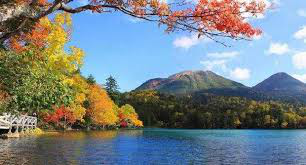

In [107]:
import torch as t
from PIL import Image
from torchvision.transforms.functional import to_tensor, to_pil_image
import numpy as np

# 读取一张图像，模拟池化操作
img = Image.open('./imgs/input.png')
img_tensor = to_tensor(img)
img

In [ ]:
img = t.tensor(np.array(img)).float()
# 将img的形状从h×w×c转化为c×h×w
img = img.transpose(0, 2).transpose(1, 2)
Cout, K, Cin=3, 3, 3
filter_pool = t.zeros(Cin, Cout, K, K)
# 初始化卷积核
filter_pool[t.arange(Cin), t.arange(Cin),:,:] = 1./K/K
# 利用卷积去模拟池化，将步长设置为卷积核的大小即可
out = Conv(img, filter_pool, stride=K)
# 将输出结果转换为h×w×c的形状，用于显示
out = out.transpose(1, 0).transpose(1, 2).long()
Image.fromarray(np.array(out, dtype=np.uint8))

可以看出，经过池化操作的图像，它的长宽都变成了原来的三分之一。

在本小节中，我们介绍了一些特殊的索引操作：整数数组索引与布尔数组索引，灵活的运用这些索引操作可以有效地完成数据的变形与转换。在小试牛刀中我们介绍了一种运用向量化思想实现卷积的方法，读者应当逐渐体会向量化计算的精妙之处。

### 6.3.4 einsum / einops

下面我们将介绍爱因斯坦操作：`einsum`和`einops`。爱因斯坦操作广泛地用于向量、矩阵和张量的运算。灵活运用爱因斯坦操作可以用非常简单的方式来表示较为复杂的多维Tensor之间的运算。

#### einsum

在数学界中，有一个由爱因斯坦提出来的求和约定，该约定能够有效处理坐标方程。爱因斯坦求和（einsum）就是基于这个法则，省略求和符号和默认成对出现的下标，从而完成对向量、矩阵和张量的运算，下面将举例说明：


In [109]:
# 转置操作
import torch as t
a = t.arange(6).view(2, 3)
b = t.einsum('ij->ji', a) # 直接交换两个维度
print(a)
print(b)

tensor([[0, 1, 2],
        [3, 4, 5]])
tensor([[0, 3],
        [1, 4],
        [2, 5]])


In [110]:
# 求和操作
a = t.arange(36).view(3, 4, 3)
b = t.einsum('ijk->', a) # 所有元素求和
b

tensor(630)

In [ ]:
a = t.arange(36).view(3, 4, 3)
b = t.arange(24).view(4, 3, 2)
c = t.einsum('ijk,jim->km', a, b)
# 此时 i=3,j=4,k=3,m=2
# 输入a是三维张量，下标是i、j和k
# 输入b是三维张量，下标是j、i和m
# 输出c是二维张量，下标是k和m
# 操作：a和b中相同的下标i和j是求和下标，结果保留了k和m
c

tensor([[2640, 2838],
        [2772, 2982],
        [2904, 3126]])

In [ ]:
# 多个张量之间的混合运算
a = t.arange(6).view(2, 3)
b = t.arange(3)
print(b.shape)
# 矩阵对应维度相乘，b进行了广播----j->ij
t.einsum('ij,j->ij', a, b)

torch.Size([3])


tensor([[ 0,  1,  4],
        [ 0,  4, 10]])

In [114]:
# 直观表达矩阵的内积和外积
a = t.arange(6).view(2, 3)
b = t.arange(6).view(3, 2)
t.einsum('ij,ij->', a, a) # 内积，结果是一个数

tensor(55)

In [117]:
t.einsum('ik,kj', a, b) # 外积，矩阵乘法的结果

tensor([[10, 13],
        [28, 40]])

#### einops

除了上面介绍的爱因斯坦求和之外，其他的爱因斯坦操作封装在`einops`中，它支持NumPy、PyTorch、Chainer、TensorFlow等多种框架的数据格式。在爱因斯坦操作中，多次转置操作不再使用`tensor_x.transpose(1, 2).transpose(2, 3)`，而是用更直观的方式：`rearrange(tensor_x, 'b c h w -> b h w c')`代替。

`einops`有很多复杂的操作，这里我们仅讲解最常见、直观的用法，并分析如何在深度学习框架中高效使用`einops`操作。有关`einops`更详细的内容示例和底层实现可以参考einops的说明文档。

In [118]:
from einops import rearrange, reduce
a = t.rand(16, 3, 64, 64)  # batch × channel × height × width
# 转置操作
rearrange(a, 'b c h w -> b h w c').shape

torch.Size([16, 64, 64, 3])

In [120]:
# 融合部分维度
y = rearrange(a, 'b c h w -> b (h w c)') # flatten
y.shape,3*64*64

(torch.Size([16, 12288]), 12288)

Transformer最初起源于NLP领域，在机器翻译等场景下取得了不错的效果。近年来，不少研究者也尝试将Transformer应用于计算机视觉领域。爱因斯坦操作由于其便捷、直观的特点，在视觉Transformer中得到了广泛的应用，下面我们以Vision Transformer（ViT）[^1]为例进行说明。假设输入是256×256的彩色图像，现在需要将其划分成8×8=64个块，每个块有32×32×3=3072个像素，使用爱因斯坦操作实现如下：

[^1]:
@article{dosovitskiy2020image,
  title={An image is worth 16x16 words: Transformers for image recognition at scale},
  author={DOSOVITSKIY A, BEYER L, KOLESNIKOV A, et al.},
  booktitle={International Conference on Learning Representations},
  year={2021},
}

In [121]:
img = t.randn(1, 3, 256, 256)
x = rearrange(img, 'b c (h p1) (w p2) -> b (p1 p2) (h w c)', p1=8, p2=8)   # p1p2融合后就是有64个块，后面的维度自行计算
x.shape

torch.Size([1, 64, 3072])

除了`rearrange`以外，常见的`einops`操作还有`reduce`，它常用于求和、求均值等操作，同时也用于搭建卷积神经网络中的池化层，下面举例说明：

In [ ]:
print(a.size())
# 对空间像素求和
y = reduce(a, 'b c h w -> b c', reduction='sum')
y.shape # 对h和w维度求和


# 对 h 和 w 这两个维度进行求和，相当于计算每个通道的所有像素点的总和。
# 维度 (64, 64) 的像素点被加总，得到一个标量，所以这两个维度被消去

torch.Size([16, 3, 64, 64])


torch.Size([16, 3])

In [127]:
# 池化操作
max_pooling = reduce(a, 'b c (h h0) (w w0) -> b c h w', reduction='max', h0=2, w0=2)
max_pooling.shape # 最大池化

torch.Size([16, 3, 32, 32])

In [128]:
global_avg_pooling = reduce(a, 'b c h w -> b c', reduction='mean')
global_avg_pooling.shape # 全局平局池化

torch.Size([16, 3])

In [129]:
# 通道归一化，将求取均值的维度结果设为1，运算时即可广播
# 对每张图像进行通道归一化
# 对于通道归一化，通常是减去每个通道的均值、再除以标准差，以消除通道间差异

y1 = a - reduce(a, 'b c h w -> b c 1 1', 'mean')   # (16, 3, 1, 1) 通过广播与原张量 (16, 3, 64, 64) 进行减法，每张图像的每个通道都会减去该图像在该通道的均值，实现归一化

# 对整个batch的图像进行通道归一化
y2 = a - reduce(a, 'b c h w -> 1 c 1 1', 'mean')

In [130]:
# 下面两种操作都可以打乱一个通道进行shuffle
tensor = t.randn(2, 16, 32, 32)
y1 = rearrange(tensor, 'b (c1 c2 c) h w -> b (c2 c1 c) h w', c1=2, c2=4)
y2 = rearrange(tensor, 'b (c0 c) h w -> b (c c0) h w', c0=4)

所有的`einops`操作都支持反向传播，可以有效地将它们嵌入到深度学习模型框架中。当我们使用`view`将卷积部分和全连接部分串联起来时，`view`只能写在forward中，而通过`einops`操作我们可以直接将维度转换的部分嵌入到网络中，从而在一个`Sequential`中构建整个网络。更多示例请读者参考einops的官方教程。

In [133]:
x0 = t.rand(16, 3, 64, 64)
x0.requires_grad = True
x1 = reduce(x0, 'b c h w -> b c', reduction='max')
x2 = rearrange(x1, 'b c -> c b')
x3 = reduce(x2, 'c b -> ', reduction='sum')

x3.backward()
x0.grad.shape
# x3.size()

torch.Size([16, 3, 64, 64])

## 6.4 小试牛刀：使用向量化思想解决实际问题

本节将实际应用向量化思想解决几个深度学习中的经典问题，读者可以在这些示例中进一步领悟向量化思想和高级索引思想。

### 6.4.1 Box_IoU

`Box_IoU`是目标检测任务中最基本的评价指标。简单来说，`Box_IoU`就是模型预测的检测结果框与原始标记框（Ground Truth）之间的交并比，如图6.4所示。

![图6-4  交并比](imgs/IoU.PNG)

目标检测中的`IoU`评价指标可以用公式(6.3)进行计算。

$$\text{IoU}=\frac{\text{Regression} \cap \text{GroundTruth}}{\text{Regression} \cup \text{GroundTruth}}\tag{6.3}$$

其中，分子部分表示两个框的交集，分母部分表示两个框的并集（这里暂时没有考虑两个框无交集的情况），二者的比值即为`IoU`的结果。

在实际问题中，我们往往通过计算`IoU`的值来判断回归框的效果。最直观的计算方法就是遍历每个Regression框与Ground Truth框，以此计算IoU，实现代码如下：

In [134]:
# 框的左上和右下的坐标，默认两个框的交集存在
Lx1, Ly1, Rx1, Ry1 = 0, 3, 3, 1 # 回归框
Lx2, Ly2, Rx2, Ry2 = 2, 2, 5, 0 # Ground Truth

area_reg = abs(Lx1 - Rx1) * abs(Ly1 - Ry1) # 回归框的面积
area_gt = abs(Lx2 - Rx2) * abs(Ly2 - Ry2) # Ground Truth的面积

inter = min(
    abs(Lx1 - Rx2) * abs(Ly1 - Ry2),
    abs(Lx2 - Rx1) * abs(Ly2 - Ry1)
) # 计算两个框交集的面积

IoU = inter / (area_reg + area_gt - inter) # 获取IoU的值
IoU

0.09090909090909091

在实际的检测问题中，对同一个Ground Truth会回归得到一组框，依次计算每一个框与Ground Truth之间的`IoU`值稍显麻烦。因此，我们可以采用向量化的思想，同时计算一组返回框的`IoU`，实现代码如下：

In [144]:
# 默认所有的Regression框都和Ground Truth有交集
# 模拟四个候选框和一个GT框
Reg = t.tensor([[0, 3, 3, 1], [1, 4, 3, 0], [1, 2, 5, 0], [-1, 2, 4, 0]])
GT = t.tensor([2, 2, 5, 0])

# 通过广播法则计算交集框的边长,dist广播为4*4
dist = (Reg - GT.reshape(1, 4)[:, [2, 3, 0, 1]]).abs()   # [:, [2, 3, 0, 1]] :表示第一维度不变，重排 GT 框的坐标顺序为 [x2, y2, x1, y1]
print('dist = ',dist)

# dist 的含义是候选框与 GT 框的每个边界距离，大小为 [4, 4]


# 计算这一组候选框分别与GT框的交集面积
inter = t.min(dist[:, [0, 2]] * dist[:, [1, 3]], dim=1) # 使用 t.min(..., dim=1)[0] 取最小值，因为交集框的宽高应是各边界之间的最小距离（相交部分重叠的最小边长）
print('inter = ',inter) # 预计形状 4*2

inter = inter[0]
print('inter[0] = ',inter)

# 计算每个返回框的面积
Reg_edge = (Reg[:, [0, 1]] - Reg[:, [2, 3]]).abs()
print('Reg_edge = ',Reg_edge) # 预计形状4*2
area_reg = Reg_edge[:, 0] * Reg_edge[:, 1]

# 计算Ground Truth框的面积
area_gt = (GT[0] - GT[2]).abs() * (GT[1] - GT[3]).abs()

# 计算这一组返回框与Ground Truth框之间的IoU值
IoU = inter.float() / (area_reg + area_gt - inter)
IoU

dist =  tensor([[5, 3, 1, 1],
        [4, 4, 1, 2],
        [4, 2, 3, 2],
        [6, 2, 2, 2]])
inter =  torch.return_types.min(
values=tensor([1, 2, 6, 4]),
indices=tensor([1, 1, 1, 1]))
inter[0] =  tensor([1, 2, 6, 4])
Reg_edge =  tensor([[3, 2],
        [2, 4],
        [4, 2],
        [5, 2]])


tensor([0.0909, 0.1667, 0.7500, 0.3333])

### 6.4.2 RoI Align

使用过Faster RCNN和Mask RCNN的读者对于RoI Pooling和RoI Align肯定十分熟悉。这两种算法的目的均为：对于具有不同特征大小的输入区域，都可以得到具有相同大小的输出特征。

具体来说，RoI Pooling的目的是将不同size的RoI（Region of Interest）区域映射到固定大小的feature map上进行池化操作，以便后续进行分类和回归。但是在映射到特征图和进行池化操作时，由于feature map的大小已经固定，因此RoI Pooling中需要进行两次量化。

（1）将RoI对应特征图与原始特征图的网格单元对齐，也就是将候选框边界量化为整数点坐标值。

（2）将第一步得到的量化RoI特征进一步细化为量化的空间单元（bin），也就是对每一个单元的边界进行量化。

然而，经过两次量化后，候选框已经与最开始的回归位置有一定偏差，也就是不匹配问题（misalignment），这一问题对于小目标来说非常致命。相比之下，RoI Align算法全程保持浮点数，通过双线性插值算法计算最后的池化结果，解决了RoI Pooling中的不匹配问题。

RoI Align算法的流程如下。

（1）遍历每个候选区域，将网格单元平均划分为$H \times W$个子网格区域（注意，与RoI Pooing不同，无需进行量化操作）。

（2）对每个区域选择4个采样点，进一步划分为4个子区域，取得每个子区域的中点。

（3）使用双线性插值算法计算这4个中点的像素值大小。

（4）通过池化操作对每个子区域进行聚合，从而得到最终的feature map。

下面我们将用向量化思想实现RoI Align算法。首先，我们从形状上分析一下这个问题的输入和输出。假设经过卷积生成的feature map的形状是$C \times H \times W$，对应的BBoxes的形状是$N \times 4$，其中$N$代表BBox的个数，$4$是左上和右下的坐标值；目标生成的池化结果是$C \times N \times n \times n$。显然，我们需要在左上和右下的坐标值的基础上构造出$n \times n$的结果，然后对feature map进行整数数组索引，从而得到一个$C \times N \times n \times n$的结果，最后相乘便完成了RoI Align操作。在流程的第（3）步中用到了双线性插值的操作，因此我们需要在计算中扩展一个用来计算双线性插值的维度，最后消去这个维度即可。双线性插值算法的原理如图6-5所示。

![图6-5  双线性插值算法](imgs/BiLinear.png)

双线性插值算法主要根据周围四个坐标点的坐标和权重，得到点$P$的插值结果。首先，我们根据点$A,B,C,D$计算出点$M$和点$N$坐标与权重，然后根据点$M$和点$N$就可以得到最终的插值结果，具体的计算方法如式(6.4)所示。

$$\begin{array}{l}
F(M)=\frac{x-x_{1}}{x_{2}-x_{1}} F(A)+\frac{x_{2}-x}{x_{2}-x_{1}} F(B) \\
F(N)=\frac{x-x_{1}}{x_{2}-x_{1}} F(C)+\frac{x_{2}-x}{x_{2}-x_{1}} F(D) \\
F(P)=\frac{y-y_{2}}{y_{1}-y_{2}} F(N)+\frac{y_{1}-y}{y_{1}-y_{2}} F(M)
\end{array}\tag{6.4}$$

其中，$F(·)$计算权重。由于$A,B,C,D$均为相邻像素的中间位置坐标，所以有$x_{2}-x_{1}=1$，$y_{1}-y_{2}=1$，因此式(6.4)可以转化为权重的形式，如式(6.5)所示。

$$\begin{aligned}F(P) &=\left(y_{1}-y\right)\left(x-x_{1}\right) F(A)+\left(y_{1}-y\right)\left(x_{2}-x\right) F(B) \\ &+\left(y-y_{2}\right)\left(x-x_{1}\right) F(C)+\left(y-y_{2}\right)\left(x_{2}-x\right) F(D)\end{aligned}\tag{6.5}$$

下面我们通过高级索引操作实现RoI Align算法：


In [150]:
def RoIAlign(BBoxes, feature_map, n):
    N = BBoxes.shape[0] # BBox的个数
    C = feature_map.shape[0]
    BBoxes = BBoxes.float()
    feature_map = feature_map.float()

    # 获取BBox边上等分点的坐标
    Xs = BBoxes[:,[0]] + t.arange(n+1).float() / n * (BBoxes[:,[2]] - BBoxes[:,[0]])     
    # t.arange(n + 1).float() / n：生成等分比例 [0, 1/n, 2/n, ..., 1]，长度为 n + 1
    Ys = BBoxes[:,[1]] + t.arange(n+1).float() / n * (BBoxes[:,[3]] - BBoxes[:,[1]])

    # 将候选框等分成 n x n 个小网格，并获取每个小网格的行列索引
    bins = t.linspace(0, n*n-1, n*n)
    idx_x, idx_y = (bins // n).long(), (bins % n).long()

    # 获取每个进行pooling的bin的中心的坐标
    # 每个池化格的中心坐标
    x = Xs[:, idx_x] + (Xs[:, [1]] - Xs[:, [0]]) / 2
    y = Ys[:, idx_y] + (Ys[:, [1]] - Ys[:, [0]]) / 2

    # 每个池化格的左上角坐标
    x_floor = x.floor().long().unsqueeze(-1)
    y_floor = y.floor().long().unsqueeze(-1)

    # 获取最近四个点的相对坐标，左上(0,0)，左下(1,0)，右下(1,1)，右上(0,1)
    corner_x = t.tensor([0, 1, 1, 0])
    corner_y = t.tensor([0, 0, 1, 1])
    idx_feature_x, idx_feature_y = x_floor + corner_x, y_floor + corner_y

    # 获取feature map中的实际值
    points = feature_map[:, idx_feature_x, idx_feature_y]

    # 利用双线性插值法计算权重ratio
    ratio_x = (x - x.floor()).unsqueeze(-1)
    ratio_y = (y - y.floor()).unsqueeze(-1)
    index1 = corner_x[None, None, :].float() 
    index2 = corner_y[None, None, :].float()
    ratio = t.abs(index1-ratio_x) * t.abs(index2-ratio_y)  # index1-ratio_x：得到目标点 (x, y) 到四个顶点在 x 方向的距离

    # 计算最终pooling的结果
    res = t.einsum('cnkp, nkp->cnkp', points, ratio)
    roialign = t.einsum('cnkp->nck', res).reshape(N, C, n, n)
    return roialign

# pooling后的大小为n*n
BBoxes = t.tensor([[50, 40, 100, 120], [30, 40, 90, 100]])
feature_map = t.arange(40000).view(1, 200, 200)
# 最终得到2组roi的结果
RoIAlign(BBoxes, feature_map, n=7).shape

torch.Size([2, 1, 7, 7])

为了便于读者理解上述流程，我们用一幅图来代替网络中的feature map，以此对RoI Align操作进行可视化。如图6-6所示，在这幅图中我们框出了八个字母，作为RoI Align处理的对象。为了保证可视化结果更加直观，我们将最后聚合得到的结果从7×7调大，以便观察。输出结果如图6-7、图6-8所示。

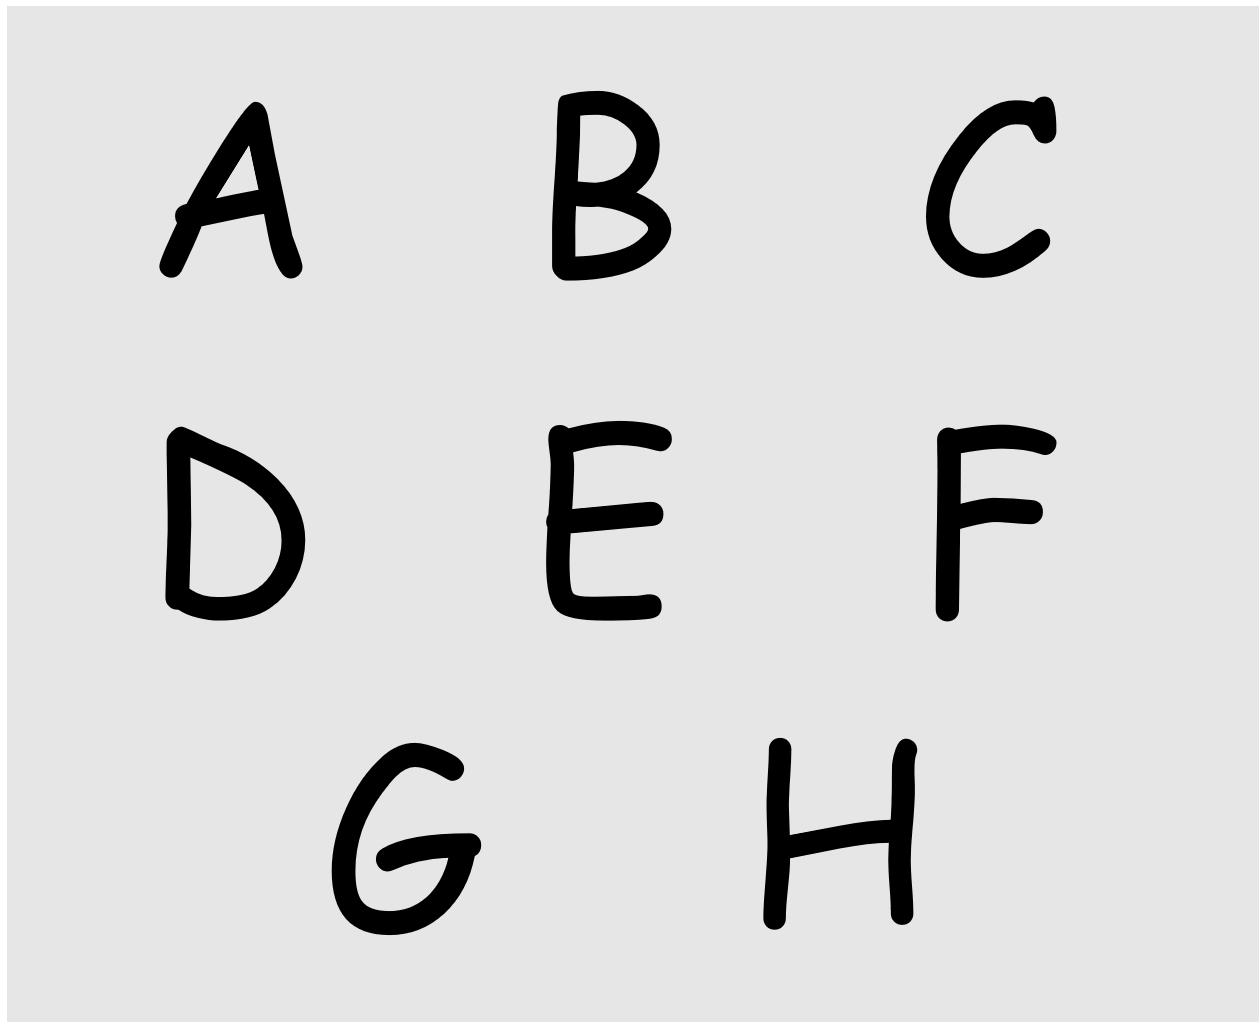

In [146]:
import torch as t
from PIL import Image
from torchvision.transforms.functional import to_tensor, to_pil_image

# 读取一张图像，模拟RoI Align操作
img = Image.open('./imgs/ROI.png')
img

In [147]:
img = to_tensor(img)
# 框出图像中的8个字母，依次从左往右、从上往下
BBoxes = t.tensor([[90, 150, 280, 320],[88, 540, 280, 690], [88, 915, 280, 1062],
                  [420, 157, 625, 315],[415, 540, 625, 675], [420, 930, 625, 1060],
                  [735, 320, 937, 485], [735, 755, 935, 918]])
# 得到目标区域的池化结果，将n调至50便于观察
rois = RoIAlign(BBoxes, img, n=50)

def show_img(img):
    return to_pil_image(img)

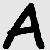

In [148]:
show_img(rois[0])

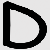

In [149]:
show_img(rois[3])

### 6.4.3 反向Unique

在PyTorch中有一个`unique`函数，它的功能是返回输入Tensor中不同的元素组成的unique list，同时返回输入Tensor对应于这个unique list的索引。当我们拿到了这个unique list和对应的索引，我们能不能还原出输入的Tensor呢？

答案是肯定的。我们可以遍历这个索引，逐个生成输入Tensor对应位置的元素，最后进行组合即可。这个过程比较繁琐，我们可以考虑使用高级索引解决这个问题。根据6.3.3节中整数数组索引的思路，这个索引的size和目标Tensor的size是一致的，因此我们可以直接使用整数数组索引对原始Tensor进行构建，具体实现如下：

In [152]:
# 随机生成一组形状为(10, 15, 10, 5)、0~9数字组成的张量
a = t.randint(1, 10, (10, 15, 10, 5))
# 获取输出的unique list和索引
output, inverse_indices = t.unique(a, return_inverse=True)
# 通过整数数组索引 还原原始tensor
a_generate = output[inverse_indices]

a_generate.equal(a)

True

可以看出，还原的Tensor值与原始值一致，这意味着使用高级索引方法可以便捷地完成反向unique操作，从而避免了耗时较长的循环遍历操作。

## 6.5 小结

本章对PyTorch中的向量化计算与高级索引进行了详细介绍。向量化思想在高维数据处理时能够有效提升计算效率，高级索引操作可以帮助我们灵活地对Tensor进行取值、切片等操作，以便进行更加复杂的计算。同时，本章通过三个示例说明了向量化思想在实际场景中的应用，读者应该仔细体会其中的向量化思想，并在解决实际问题时尝试使用向量化思想进行编程，从而提高程序的运行效率。